# Parallel Ensemble Learning of Convolutional Neural Network and Local Binary Pattern for Face Recognition

# Install Dependencies

In [ ]:
!pip install torch torchvision Pillow scikit-image tqdm torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import os
import math
from abc import ABC, abstractmethod

from google.colab import drive

import numpy as np

from IPython.display import display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from tqdm.auto import tqdm
from torchinfo import summary

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

print(torch.__version__)
print(torchvision.__version__)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

1.13.0+cu116
0.14.0+cu116


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Constants

In [ ]:
ORL_DATASET_PATH = '/content/gdrive/MyDrive/Colab Notebooks/dataset/orl'
YALEB_DATASET_PATH = '/content/gdrive/MyDrive/Colab Notebooks/dataset/yale'

# Cleanup

# Preprocess Dataset

In [ ]:
class ImageClassificationDataset(ABC, Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset[0])

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    image, label = Image.open(self.dataset[0][idx]), self.dataset[1][idx]
    
    if self.transform:
      image = self.transform(image)
    
    return image, label

  @abstractmethod
  def loadDataset(self):
    pass

## ORL Dataset

In [ ]:
class ORLDataset(ImageClassificationDataset):
  def __init__(self, transform=None):
    images, labels = self.loadDataset()

    self.number_of_categories = np.unique(labels).size

    super().__init__((images, labels), transform)

  def loadDataset(self):
    files = os.listdir(ORL_DATASET_PATH)
    images, labels = list(), list()

    for file in files:
      base, ext = os.path.splitext(file)
      num, cl = base.split('_')

      images.append(ORL_DATASET_PATH + '/' + file)
      labels.append(int(cl) - 1)

    return images, labels

## Yale-B Dataset

In [ ]:
class YaleBDataset(ImageClassificationDataset):
  def __init__(self, transform=None):
    images, labels = self.loadDataset()

    self.number_of_categories = np.unique(labels).size

    super().__init__((images, labels), transform)

  def loadDataset(self):
    files = os.listdir(YALEB_DATASET_PATH)
    images, labels = list(), list()

    for file in files:
      base, ext = os.path.splitext(file)
      cl = int(base[-2]) * 10 + int(base[-1]) 

      images.append(YALEB_DATASET_PATH + '/' + file)
      labels.append(int(cl) - 1)

    return images, labels

## Pytorch Transformers and DataLoaders

In [ ]:
IMG_SIZE = 64

In [ ]:
from skimage.feature import local_binary_pattern
class LocalBinaryPatternTransform:
  # define a function to compute the local binary pattern of an image
  def localBinaryPattern(self, img):
    # Apply LBP to the grayscale image
    lbp_image = local_binary_pattern(img, 8, 1, 'default')
    return lbp_image.astype(np.uint8)

  def __call__(self, img):
    return self.localBinaryPattern(img)
    
train_transformer = transforms.Compose([
  transforms.Grayscale(),
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.TrivialAugmentWide(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  LocalBinaryPatternTransform(),
  transforms.ToTensor(), # [0, 255] to [0, 1], numpy to tensors
  transforms.Normalize(0.5, # [0, 1] to [-1, 1], formula => (x - mean) / std, here mean = 0.5 and std = 0.5 for every channel (here it is 1 as we applied lbp)
                       0.5)
])

valid_transformer = transforms.Compose([
  transforms.Grayscale(),
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  LocalBinaryPatternTransform(),
  transforms.ToTensor(), # [0, 255] to [0, 1], numpy to tensors
  transforms.Normalize(0.5, # [0, 1] to [-1, 1], formula => (x - mean) / std, here mean = 0.5 and std = 0.5 for every channel (here it is 1 as we applied lbp)
                       0.5)
])

# Prepare the dataset for training

In [ ]:
# dataset = ORLDataset(transform=train_transformer)
dataset = YaleBDataset(transform=train_transformer)

train_set_size = int(len(dataset) * 0.8)
valid_set_size = len(dataset) - train_set_size

train_dataset, valid_dataset = random_split(dataset, [train_set_size, valid_set_size])

# Models

## Hyperparameters

In [ ]:
EPOCHS = 32
BATCH_SIZE = 8
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.3

## Ensemble Model

In [ ]:
# ensemble of convolutional neural networks
class Ensemble(nn.Module):
    def __init__(self, models, device_ids):
      super().__init__()

      self.models = models
      self.criterion = nn.CrossEntropyLoss() # softmax is already implemented

      # weight_decay is used for L2 regularization(Ridge regression adds "squared magnitude" of coefficient as penalty term to the loss function)
      # L1 regulariztion is Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds "absolute value of magnitude" of coefficient as penalty term to the loss function.
      self.optimizer = optim.Adam(self.models.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
      # self.optimizer = optim.SGD(self.models.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

      self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=16, gamma=0.1)

      # use DataParallel to run the models in parallel on multiple GPUs
      self.parallel = nn.DataParallel(self.models, device_ids)

    def forward(self, x):
      # # apply each model to the input and return the average output
      outputs = [model(x) for model in self.models]

      max_output, max_indices = torch.max(torch.stack(outputs), dim=0)
      
      # Return the maximum output value
      return max_output

## Convolutional Neural Network Models

### Structure A

In [ ]:
# we haven't implemented skip connection and dropout, and we used batch normalization as opposed to layer normalization
# For a CNN, the 'kernel' is the 'weight matrix' and that is essentially what the network is trying to learn
# define the convolutional neural network
class CNNA(nn.Module):
  def __init__(self, channels, classes):
    super(CNNA, self).__init__()
    # Input Shape: (1, IMG_SIZE, IMG_SIZE)

    # output size of convolution filter = (w - f + 2P) / S + 1, where w is width, f is kernel size, p is padding, s is stride

    # every input_channel has its own filter, and every out_channel corresponds to a how many filters to have in each filter bank => here 1 * 4 kernels
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=8, kernel_size=3, stride=1, padding=1, dilation=1, padding_mode='zeros', groups=1, bias=False) # same shape convolution, bias is set to false as the batch norm’s beta parameter (bias of nn.BatchNorm) will have the same effect and the bias of the conv layer might be canceled out by the mean subtraction.
    self.bn1 = nn.BatchNorm2d(num_features=8)

    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, dilation=1, bias=False) # same shape convolution
    self.bn2 = nn.BatchNorm2d(num_features=16)

    # after pooling, size will width and height will decrease by a factor of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Shape: (16, IMG_SIZE / 2, IMG_SIZE / 2)

    """
    In CNN the output feature maps are sensitive to the location of features in the input. 
    If the input image is translated the output feature map will also be affected by the translation,
    so that small movements in the position of the feature in the input image will result in a different feature map.
    One way to adress this sensitivity problem is using pooling layers, because of their down sampling ability.
    Pooling layers create a lower resolution version of the input that still contains the large or important structural elements,
    without the fine details which may be not usefull for the task.

    So the max pooling layer makes the image unclear for the human eye by sampling it down to a lower resolution,
    but for the machine learning model it mostly removes not relevant elements and makes it more robust to changes in the input (like rotation, shifting, translation etc.)
    """

    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Shape: (16, IMG_SIZE / 4, IMG_SIZE / 4)

    self.fc1 = nn.Linear(in_features=16 * IMG_SIZE // 4 * IMG_SIZE // 4, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=classes)

  def forward(self, x):
    """
    Typically, dropout is applied after the non-linear activation function (a). 
    However, when using rectified linear units (ReLUs), 
    it might make sense to apply dropout before the non-linear activation (b) 
    for reasons of computational efficiency depending on the particular code implementation.
    """

    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(x)

    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool2(x)

    x = torch.flatten(x, start_dim=1) # flattening, It takes in a tensor and the start dimension start_dim as input and returns a new tensor that has all the dimensions after start_dim flattened into one

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### Structure B

In [ ]:
class CNNB(nn.Module):
  def __init__(self, channels, classes):
    super(CNNB, self).__init__()

    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=channels, out_channels=4, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
      nn.BatchNorm2d(num_features=4),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(kernel_size=2, stride=2),
      
      nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, dilation=1, bias=False),
      nn.BatchNorm2d(num_features=8),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
      nn.Linear(in_features=8 * IMG_SIZE // 4 * IMG_SIZE // 4, out_features=32),
      nn.Linear(in_features=32, out_features=classes)
    )

  def forward(self, x):
    x = self.conv_layers(x)

    x = torch.flatten(x, start_dim=1)

    x = self.classifier(x)
    return x

### Structure C

In [ ]:
class CNNC(nn.Module):
  def __init__(self, channels, classes):
    super(CNNC, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=16 * IMG_SIZE // 2 * IMG_SIZE // 2, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=classes)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(x)

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### Structure D

In [ ]:
class CNND(nn.Module):
  def __init__(self, channels, classes):
    super(CNND, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=8, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=8)
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=8 * IMG_SIZE // 2 * IMG_SIZE // 2, out_features=32)
    self.fc2 = nn.Linear(in_features=32, out_features=classes)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(x)

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### Structure E

In [ ]:
class CNNE(nn.Module):
  def __init__(self, channels, classes):
    super(CNNE, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(in_features=16 * IMG_SIZE // 2 * IMG_SIZE // 2, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=classes)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool1(x)

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

# Load the data to Pytorch Dataloaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# Train Model

In [ ]:
# get the number of GPUs on the system
num_gpus = torch.cuda.device_count()

# set device
device = torch.device('cuda' if num_gpus else 'cpu')

device_ids = list(range(num_gpus))
device_ids

# clear the GPUs
torch.cuda.empty_cache()

In [ ]:
classes = dataset.number_of_categories

cnn_models = nn.ModuleList()

cnn_models.extend([CNNA(1, classes) for _ in range(3)])
cnn_models.extend([CNNB(1, classes) for _ in range(2)])
cnn_models.extend([CNNC(1, classes) for _ in range(3)])
cnn_models.extend([CNND(1, classes) for _ in range(1)])
cnn_models.extend([CNNE(1, classes) for _ in range(1)])

ensemble = Ensemble(cnn_models, device_ids)
model = nn.DataParallel(ensemble, device_ids) # parallelizing the entire ensemble model, forward of inputs 

## Model Summary

In [ ]:
summary(ensemble, input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
Ensemble                                      [8, 15]                   --
├─DataParallel: 1-1                           --                        --
│    └─ModuleList: 2-1                        --                        --
│    │    └─CNNA: 3-1                         [8, 15]                   264,455
│    │    └─CNNA: 3-2                         [8, 15]                   264,455
│    │    └─CNNA: 3-3                         [8, 15]                   264,455
│    │    └─CNNB: 3-4                         [8, 15]                   66,411
│    │    └─CNNB: 3-5                         [8, 15]                   66,411
│    │    └─CNNC: 3-6                         [8, 15]                   1,049,791
│    │    └─CNNC: 3-7                         [8, 15]                   1,049,791
│    │    └─CNNC: 3-8                         [8, 15]                   1,049,791
│    │    └─CNND: 3-9                         [8, 1

In [ ]:
summary(CNNA(1, classes), input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNNA                                     [8, 15]                   --
├─Conv2d: 1-1                            [8, 8, 64, 64]            72
├─BatchNorm2d: 1-2                       [8, 8, 64, 64]            16
├─MaxPool2d: 1-3                         [8, 8, 32, 32]            --
├─Conv2d: 1-4                            [8, 16, 32, 32]           1,152
├─BatchNorm2d: 1-5                       [8, 16, 32, 32]           32
├─MaxPool2d: 1-6                         [8, 16, 16, 16]           --
├─Linear: 1-7                            [8, 64]                   262,208
├─Linear: 1-8                            [8, 15]                   975
Total params: 264,455
Trainable params: 264,455
Non-trainable params: 0
Total mult-adds (M): 13.90
Input size (MB): 0.13
Forward/backward pass size (MB): 6.30
Params size (MB): 1.06
Estimated Total Size (MB): 7.49

In [ ]:
summary(CNNB(1, classes), input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNNB                                     [8, 15]                   --
├─Sequential: 1-1                        [8, 8, 16, 16]            --
│    └─Conv2d: 2-1                       [8, 4, 64, 64]            36
│    └─BatchNorm2d: 2-2                  [8, 4, 64, 64]            8
│    └─LeakyReLU: 2-3                    [8, 4, 64, 64]            --
│    └─MaxPool2d: 2-4                    [8, 4, 32, 32]            --
│    └─Conv2d: 2-5                       [8, 8, 32, 32]            288
│    └─BatchNorm2d: 2-6                  [8, 8, 32, 32]            16
│    └─LeakyReLU: 2-7                    [8, 8, 32, 32]            --
│    └─MaxPool2d: 2-8                    [8, 8, 16, 16]            --
├─Sequential: 1-2                        [8, 15]                   --
│    └─Linear: 2-9                       [8, 32]                   65,568
│    └─Linear: 2-10                      [8, 15]                   495
Total para

In [ ]:
summary(CNNC(1, classes), input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNNC                                     [8, 15]                   --
├─Conv2d: 1-1                            [8, 16, 64, 64]           144
├─BatchNorm2d: 1-2                       [8, 16, 64, 64]           32
├─MaxPool2d: 1-3                         [8, 16, 32, 32]           --
├─Linear: 1-4                            [8, 64]                   1,048,640
├─Linear: 1-5                            [8, 15]                   975
Total params: 1,049,791
Trainable params: 1,049,791
Non-trainable params: 0
Total mult-adds (M): 13.12
Input size (MB): 0.13
Forward/backward pass size (MB): 8.39
Params size (MB): 4.20
Estimated Total Size (MB): 12.72

In [ ]:
summary(CNND(1, classes), input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNND                                     [8, 15]                   --
├─Conv2d: 1-1                            [8, 8, 64, 64]            72
├─BatchNorm2d: 1-2                       [8, 8, 64, 64]            16
├─AvgPool2d: 1-3                         [8, 8, 32, 32]            --
├─Linear: 1-4                            [8, 32]                   262,176
├─Linear: 1-5                            [8, 15]                   495
Total params: 262,759
Trainable params: 262,759
Non-trainable params: 0
Total mult-adds (M): 4.46
Input size (MB): 0.13
Forward/backward pass size (MB): 4.20
Params size (MB): 1.05
Estimated Total Size (MB): 5.38

In [ ]:
summary(CNNE(1, classes), input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNNE                                     [8, 15]                   --
├─Conv2d: 1-1                            [8, 16, 64, 64]           144
├─BatchNorm2d: 1-2                       [8, 16, 64, 64]           32
├─AvgPool2d: 1-3                         [8, 16, 32, 32]           --
├─Linear: 1-4                            [8, 64]                   1,048,640
├─Linear: 1-5                            [8, 15]                   975
Total params: 1,049,791
Trainable params: 1,049,791
Non-trainable params: 0
Total mult-adds (M): 13.12
Input size (MB): 0.13
Forward/backward pass size (MB): 8.39
Params size (MB): 4.20
Estimated Total Size (MB): 12.72

In [ ]:
%%time
train_losses = []
train_accs = []
valid_accs = []

best_acc = 0.0

for epoch in tqdm(range(EPOCHS), desc=None):
  model.train()
  train_acc = 0.0
  train_loss = 0.0
  train_size = len(train_loader)
  
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    model.zero_grad() # backward function accumulates gradients, and we don't want to mix up the gradients between the mini-batches; we 0 them out
    outputs = model(images)
    loss = ensemble.criterion(outputs, labels)

    # after we do a backward, the gradients can be accessed for the computational graph
    loss.backward()
    # after calculating the loss, we get a scalar so we can call the grad for other tensors, but for any reason if we don't get a scalar, we need to pass a vector to .backward(v) as pytorch uses product of jacobian and the vector to calculate the gradient

    # we do a Tensor -= lr * Tensor.grad, Tensor.grad will be the gradient, lr is learning rate
    # and finally do, Tensor.grad.zero_()

    ensemble.optimizer.step() # update the weights and biases

    train_loss += loss.item() / len(labels)
    _, prediction = torch.max(outputs.data, 1)

    train_acc += int(torch.sum(prediction == labels.data)) / len(labels)

  # update the scheduler on every epoch
  ensemble.scheduler.step()
  
  # average accuracy and loss across all mini-batches
  train_acc /= train_size
  train_loss /= train_size

  train_accs.append(train_acc)
  train_losses.append(train_loss)

  model.eval()

  valid_acc = 0.0
  valid_loss = 0.0

  valid_size = len(valid_loader)
  # also if at any time, we want to perform some operations on the weights and not be part of the gradient computation, we use Tensor.requires_grad_(False) or, Tensor.detach() or wrap in a context manager: with torch.no_grad(): or with torch.inference_mode():
  with torch.inference_mode():
    for images, labels in valid_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = ensemble.criterion(outputs, labels)
      
      valid_loss += loss.item() / len(labels)
      _, prediction = torch.max(outputs.data, 1)

      valid_acc += int(torch.sum(prediction == labels.data)) / len(labels)

    valid_acc /= valid_size
    valid_loss /= valid_size

    valid_accs.append(valid_acc)

    # save the model
    if valid_acc > best_acc:
      torch.save(model.state_dict(), 'best_checkpoint.model')
      best_acc = valid_acc

    print('Train Loss: {:.4f}, Train Acc: {:.4f} | Validation Loss: {:.4f}, Validation Acc: {:.4f}'.format(train_loss, train_acc, valid_loss, valid_acc))

  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.6062, Train Acc: 0.1094 | Validation Loss: 1.2545, Validation Acc: 0.1250
Train Loss: 0.4104, Train Acc: 0.1562 | Validation Loss: 0.7284, Validation Acc: 0.1500
Train Loss: 0.3038, Train Acc: 0.2891 | Validation Loss: 1.2012, Validation Acc: 0.2250
Train Loss: 0.3311, Train Acc: 0.2422 | Validation Loss: 0.6276, Validation Acc: 0.2750
Train Loss: 0.2667, Train Acc: 0.3594 | Validation Loss: 1.2285, Validation Acc: 0.2000
Train Loss: 0.2606, Train Acc: 0.3906 | Validation Loss: 1.1261, Validation Acc: 0.2250
Train Loss: 0.2246, Train Acc: 0.4922 | Validation Loss: 0.6438, Validation Acc: 0.1500
Train Loss: 0.2904, Train Acc: 0.3516 | Validation Loss: 0.3451, Validation Acc: 0.5750
Train Loss: 0.2476, Train Acc: 0.4453 | Validation Loss: 0.4756, Validation Acc: 0.2750
Train Loss: 0.2511, Train Acc: 0.4062 | Validation Loss: 0.3897, Validation Acc: 0.5250
Train Loss: 0.2126, Train Acc: 0.4922 | Validation Loss: 1.6050, Validation Acc: 0.4250
Train Loss: 0.1903, Train Acc: 0

In [ ]:
print(f'Best Accuracy: {best_acc:.4f}')

Best Accuracy: 0.7000


# Metrics

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)

## Training Metrics

### Training Loss

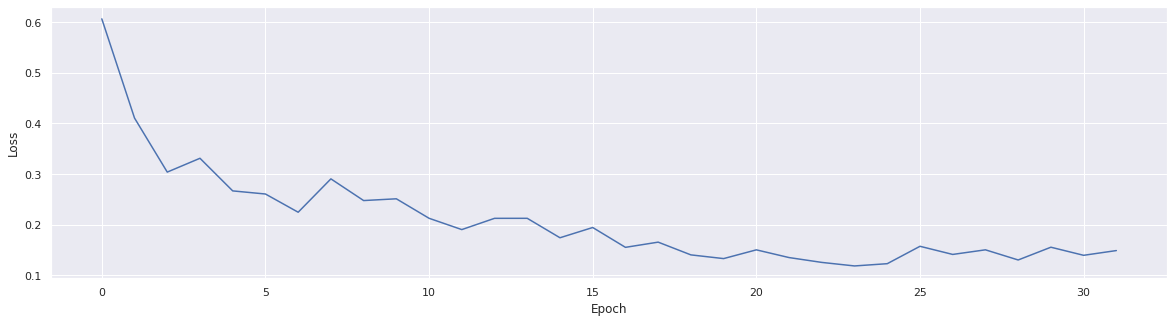

In [ ]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Training Accuracy

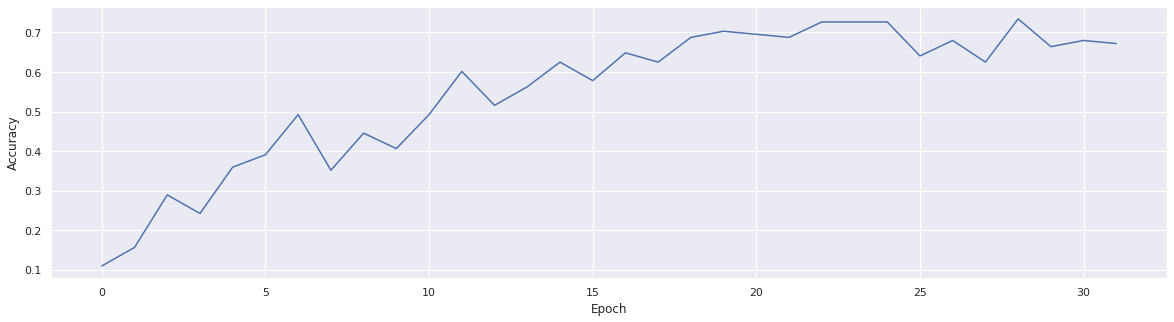

In [ ]:
plt.plot(train_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Validation Metrics

### Validation Accuracy

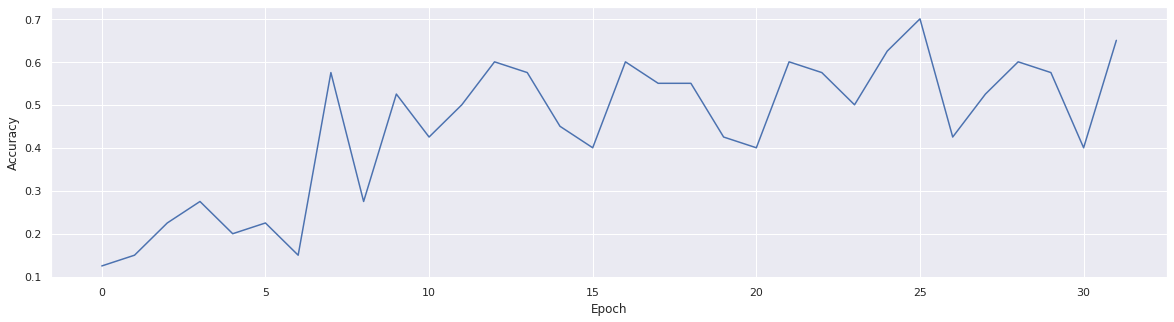

In [ ]:
plt.plot(valid_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Cleanup

In [ ]:
# clear the GPUs
torch.cuda.empty_cache()

# Visualize the convolution layer image

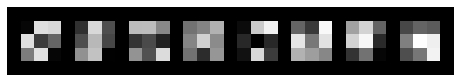

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))


if __name__ == "__main__":
    layer = 1
    filter = ensemble.models[0].conv1.weight.data.clone()
    visTensor(filter, ch=0, allkernels=False)

    plt.axis('off')
    plt.ioff()
    plt.show()